### Ch 1: From correlation to causation

Till now, we have learnt about Bayesian Networks and how they help define a large joint distribution in a modular way. But traditional bayesian networks have one fundamental limitation, they dont help us understand the causal relationships involved.

You might be wondering why this matters?

Let us say you are an urban planner deciding where to build cities and you know nothing about the world you are working in. But you have data which shows:
* Cities at high altitude are colder
* Cities at lower altitude are warmer

Your first task is to buld a warm city. Based on the data you have:
* Should you build at a low altitude (where the warmer cities are)?
* Or could you get away with building the city at a higher altitude and then install heaters? But then you might be risking the city descending down as warm cities tend to be at lower altitudes.

Note: Option 2 sounds weird. But from a purely mathematical persepective, both correlations make sense.

Thanks to physics and concepts like lapse rate, we know that altitude affects temperature and not the other way around. But can we discover this fact purely from data alone?

Through this chapter, we will explore the limitations of traditional bayesian networks and introduce structural causal models. We will use a running example throughout, which is the relationship between a city's altitude and its average temperature and learn to find the causal direction and not just correlation.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

np.random.seed(42)

### Altitude-Temperature Example

We have data from European cities showing their altitude and average temperature. There's a clear correlation which is higher cities tend to be cooler.

What we are trying to find out is the causal direction:
- Does altitude cause temperature? $(A -> T)$, or
- Does temperature cause altitude? $(T -> A)$

Thanks to physics and concepts like the lapse rate, we know altitude affects temperature, but let's see if we can discover this from data alone!



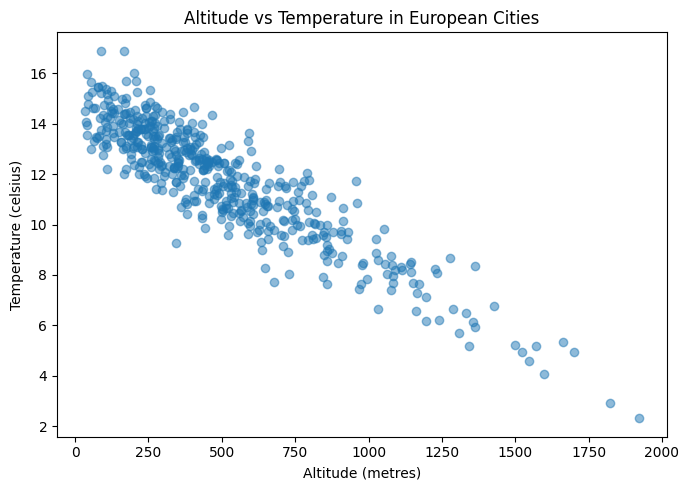

In [8]:
def generate_city_data(number=500):
    """
    Generate altitude-temperature data
    Causal relationship: Altitude -> Temperature
    (Lapse rate from physics: temperature drops ~6.5C per 1000m altitude)
    """
    altitude = np.random.gamma(2, 250, number)
    temperature = 15 - 0.0065 * altitude + np.random.normal(0, 1, number)
    return altitude, temperature

A, T = generate_city_data()

# Plot results
plt.figure(figsize=(7, 5))
plt.scatter(A, T, alpha = 0.5)
plt.xlabel('Altitude (metres)')
plt.ylabel('Temperature (celsius)')
plt.title('Altitude vs Temperature in European Cities')
plt.tight_layout()
plt.show()

In Bayesian networks, we first specify a directed acyclic graph (DAG), then factorize the joint distribution accordingly. For two variables altitude $A$
and temperature $T$, we have two options:

1. DAG: $A$ -> $T$
$$P(A,T) = P(T|A)P(A)$$
2. DAG: $T$ -> $A$
$$P(A,T) = P(A|T)P(T)$$

Both factorizations are mathematically valid for the same joint distribution using the chain rule.

**Let's test this:** We will fit regressions for both directions and see if one fits better

In [9]:
df = pd.DataFrame({'A': A, 'T': T})

# A -> T
# Linear regression
model_1 = smf.ols('T ~ 1 + A', data=df).fit()
print("Direction A -> T")
print(f"T = {model_1.params['Intercept']:.2f} + ({model_1.params['A']:.2f}) * A")
print(f"R squared = {model_1.rsquared:.4f}")
print("--")

# T -> A
model_2 = smf.ols('A ~ 1 + T', data=df).fit()
print("Direction T -> A")
print(f"A = {model_2.params['Intercept']:.1f} + ({model_2.params['T']:.2f}) * T")
print(f"R squared = {model_2.rsquared:.4f}")

Direction A -> T
T = 14.90 + (-0.01) * A
R squared = 0.8273
--
Direction T -> A
A = 2048.9 + (-131.79) * T
R squared = 0.8273


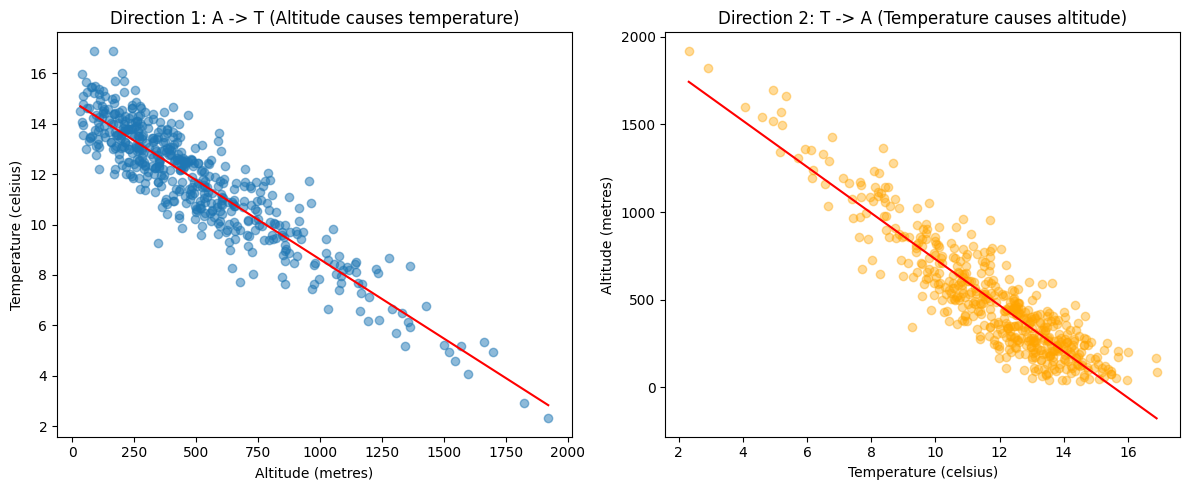

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# A -> T
ax1.scatter(A, T, alpha = 0.5)
x_values_1 = np.linspace(A.min(), A.max(), 100)
y_values_1 = model_1.params['Intercept'] + model_1.params['A'] * x_values_1
ax1.plot(x_values_1, y_values_1, 'r-')
ax1.set_xlabel('Altitude (metres)')
ax1.set_ylabel('Temperature (celsius)')
ax1.set_title('Direction 1: A -> T (Altitude causes temperature)')

# T -> A
ax2.scatter(T, A, alpha=0.4, color='orange')
x_values_2 = np.linspace(T.min(), T.max(), 100)
y_values_2 = model_2.params['Intercept'] + model_2.params['T'] * x_values_2
ax2.plot(x_values_2, y_values_2, 'r-')
ax2.set_xlabel('Temperature (celsius)')
ax2.set_ylabel('Altitude (metres)')
ax2.set_title('Direction 2: T -> A (Temperature causes altitude)')

plt.tight_layout()
plt.show()

Both lines fit equally well and can be used for strong correlations between the variables.

The problem is that traditional Bayesian networks can't tell us which direction is causal.

**We need something more...**

### Adding causality using Structural Causal Models

A **Structural Causal Model** uses assignments (:=) to show how variables are generated.

$$A := N_A$$
$$T := 15 - 0.0065 * A + N_T$$

where $N_A \perp \perp N_T$ (independent noises)

Key differences from Bayesian networks:
- We use **:=** which denotes assignment
- We show A is generated first, then T is computed from A
- This then encodes that A causes T

The regression we fit that captures the mechanism is $P(T|A)$

### What does the do-operator do?


**Observation P(T | A = 1000):**
- Looks at cities that already exist at 1000m altitude

**Intervention P(T | do(A := 1000)):**
- We somehow lift all the cities to be at 1000m altitude  
- We actively intervene in the system

In [11]:
print("Doing the intervention")
print("---------")

# Generate data
A_observed, T_observed = generate_city_data(500)

#  First intervention: set all altitudes to 1000m
A_int1 = np.full(500, 1000)
T_int1 = 15 - 0.006 * A_int1 + np.random.normal(0, 2, 500)

# Second intervention: set all temperatures to 10 celsius
A_int2 = np.random.gamma(2, 250, 500)
T_int2 = np.full(500, 10)

print(f"Observational:     Mean A = {A_observed.mean():.0f}m,  Mean T = {T_observed.mean():.1f} celsius")
print(f"After do(A:=1000): Mean A = 1000m, Mean T = {T_int1.mean():.1f} celsius")
print(f"After do(T:=10):   Mean A = {A_int2.mean():.0f}m (almost same), Mean T = 10 celsius")
print()
print("Changing A changes T, but changing T doesn't really change A")

Doing the intervention
---------
Observational:     Mean A = 509m,  Mean T = 11.8 celsius
After do(A:=1000): Mean A = 1000m, Mean T = 8.9 celsius
After do(T:=10):   Mean A = 522m (almost same), Mean T = 10 celsius

Changing A changes T, but changing T doesn't really change A


### Summary

**The Problem:**
- Bayesian networks can represent P(A,T) in multiple ways
- All factorizations fit the data equally well
- Correlation doesn't reveal causation

**Solution:**
- **Structural Causal Models** use assignments (:=) to encode causality
- **Interventions** (do-operator) test what happens when we force changes
- Only the correct causal direction shows the right effects of the intervention

**Takeaways:**
- Intervention != Observation
- do(A := 1000) means "force A to be 1000 and see what happens to T"

**Next steps:** Many times, due to ethical or practical constrains, we cannot directly implement interventions like those mentioned above. In the next chapter, we'll learn how to discover causality from observational data using the principle of independent mechanisms.